# Loading CSV to Notebook

I started by importing all the relevant libraries needed for my analysis.

In [1]:
# Importing Relevant Libraries and loading env variables
import os
import sys
import requests
import math
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

load_dotenv()

True

Then I loaded the dataset into a dataframe called df

In [2]:
# Loading the csv file
df = pd.read_csv("challenge_dataset_business_travel.csv")

df.head()

,Id,DepartureLocationCountry,DepartureLocationCity,ArrivalLocationCountry,ArrivalLocationCity,ShippingType,ShippingTypeDescription,Purpose,OutOfPolicy,EntitiyCode,EmployeeNumber,BusinessUnit,HotelNights,NetCosts
0,1,CN,Beijing,IN,New Delhi,12,Business Class Flight,Customer Visit,No,9000,M1000-M5008,Services,1,1200
1,2,BR,São Paulo,ZA,Johannesburg,12,Business Class Flight,Customer Visit,Yes,8000,M1000-M5012,Sales,2,2400
2,3,US,New York,MX,Mexico City,11,First Class Flight,Customer Visit,Yes,6000,M1000-M5030,Sales,2,450
3,4,CN,Beijing,GB,London,10,Economy Flight,Internal Business Trip,No,8000,M1000-M5049,Customer Support,2,450
4,5,AU,Sydney,US,Los Angeles,10,Economy Flight,Conference/Exhibition,No,8000,M1000-M5062,Marketing,3,3450


Here, I check if any column had null values. I can see all the rows of my table in all columns have corresponding values 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87053 entries, 0 to 87052
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Id                        87053 non-null  int64 
 1   DepartureLocationCountry  87053 non-null  object
 2   DepartureLocationCity     87053 non-null  object
 3   ArrivalLocationCountry    87053 non-null  object
 4   ArrivalLocationCity       87053 non-null  object
 5   ShippingType              87053 non-null  int64 
 6   ShippingTypeDescription   87053 non-null  object
 7   Purpose                   87053 non-null  object
 8   OutOfPolicy               87053 non-null  object
 9   EntitiyCode               87053 non-null  int64 
 10  EmployeeNumber            87053 non-null  object
 11  BusinessUnit              87053 non-null  object
 12  HotelNights               87053 non-null  int64 
 13  NetCosts                  87053 non-null  int64 
dtypes: int64(5), object(9)

# 1. Exploratory Data Analysis

First things first, I would like to understand what information consists of in the dataset. I know it is about business trips, yet I would like to see if some data is more predominant than others.<br>To do so, I started with segmenting the column 'HotelNights' into 3 categories:<br>
- short stay (1-2 nights)
- medium stay (3-4 nights)
- long stay (5+ nights)

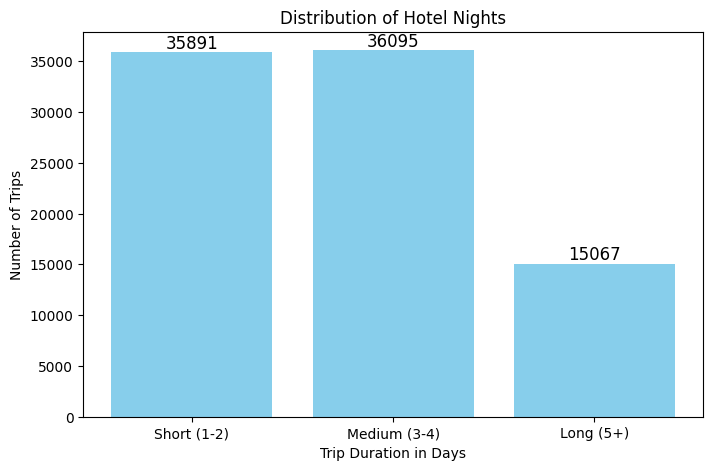

In [4]:
short_stay_count = (df['HotelNights'] <= 2).sum()
medium_stay_count = ((df['HotelNights'] > 2) & (df['HotelNights'] <= 4)).sum()
long_stay_count = (df['HotelNights'] >= 5).sum()

labels = ['Short (1-2)', 'Medium (3-4)', 'Long (5+)']
counts = [short_stay_count, medium_stay_count, long_stay_count]

# Create the bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts, color='skyblue')
plt.xlabel('Trip Duration in Days')
plt.ylabel('Number of Trips')
plt.title('Distribution of Hotel Nights')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', 
             ha='center', va='bottom', fontsize=12)

plt.show()

We can clearly see the dataset is largely comprised of short and medium stays.<br>The short and medium stay category has more than double of the amount of long stays.<br> Now let's explore the dataset in regards to the distribution between TravelMode, meaning what medium of transport did the employee take for their trip (flight, car, train).

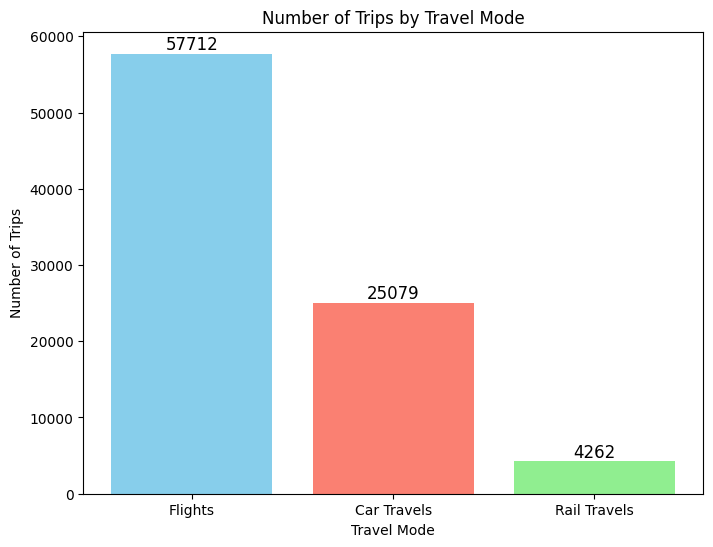

In [5]:
# Count trips for each travel mode
num_flights = df['ShippingTypeDescription'].str.contains("Flight", case=False, na=False).sum()
num_rails = df['ShippingTypeDescription'].str.contains("Train", case=False, na=False).sum()
num_cars = len(df) - num_flights - num_rails

# Define labels and corresponding counts
labels = ["Flights", "Car Travels", "Rail Travels"]
counts = [num_flights, num_cars, num_rails]

# Creating the bar chart
plt.figure(figsize=(8,6))
bars = plt.bar(labels, counts, color=['skyblue', 'salmon', 'lightgreen'])
plt.xlabel("Travel Mode")
plt.ylabel("Number of Trips")
plt.title("Number of Trips by Travel Mode")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', 
             ha='center', va='bottom', fontsize=12)

plt.show()

We can observe the dataset in comprised majorely of flights, which are more than the double amount of car travels.<br>Rail travels appear to be the least chosen option by employees only accounting for:
- less than 1/5 of car travels
- less than 1/10 of flights.<br>

Now let's dive into the flight class distribution, I can see 3 different classes available: economy, business, first.

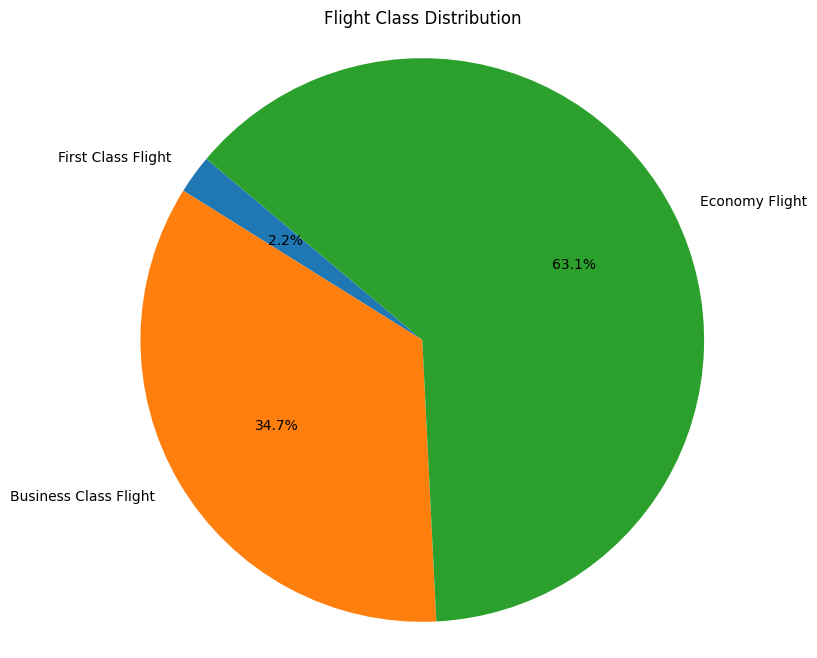

In [6]:
# Calculate the counts
num_Fflight = df['ShippingTypeDescription'].str.contains("First Class Flight", case=False, na=False).sum()
num_Bflight = df['ShippingTypeDescription'].str.contains("Business Class Flight", case=False, na=False).sum()
num_Eflight = df['ShippingTypeDescription'].str.contains("Economy Flight", case=False, na=False).sum()

# Labels and corresponding sizes for the pie chart
labels = ['First Class Flight', 'Business Class Flight', 'Economy Flight']
sizes = [num_Fflight, num_Bflight, num_Eflight]

# Creating the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Flight Class Distribution")
plt.axis('equal') 
plt.show()

Once again, the data is not uniformed, economy flights predominate air travels in this dataset, followed by business travels.<br>First Class travels are the least common in the dataset, which makes sense from a cost perspective (economy being the cheapeast, first being the most expensive).

# 2. Cleaning the DataSet to enable integration with Climatiq Distance-based API

Now, we can grasp the predominant elements within the dataset and the less recurring ones; we need to clean the information in order to be able to enrich the dataset with Climatiq's API.<br>The first thing to do is creating a column to distinguish car travels, from flights and rail travels.<br>This cleaning process will be two-folds:
- once the data is cleaned, we will call the distance-based emissions API
- then the spend-based emissions API

## 2.1 Preparing the data for the Distance-based emission API

Our dataset enables us to get the following params for the distance based emissions API:
- travel_mode (air, train, car)
- origin
- destination
- car_details or air_details (types of car or flight class)  
<br>We already have the destination and origin, we need to create columns for the rest.

In [7]:
# Create new column for ModeOfTransport (plane, car, train) for travel_type request param
conditions = [
    (df['ShippingTypeDescription'].str.lower().str.contains("flight")),
    (df['ShippingTypeDescription'].str.lower().str.contains("train"))
    ]
choices = ['air', 'rail']
df['ModeOfTransport'] = np.select(conditions, choices, default='car')

df.head()


,Id,DepartureLocationCountry,DepartureLocationCity,ArrivalLocationCountry,ArrivalLocationCity,ShippingType,ShippingTypeDescription,Purpose,OutOfPolicy,EntitiyCode,EmployeeNumber,BusinessUnit,HotelNights,NetCosts,ModeOfTransport
0,1,CN,Beijing,IN,New Delhi,12,Business Class Flight,Customer Visit,No,9000,M1000-M5008,Services,1,1200,air
1,2,BR,São Paulo,ZA,Johannesburg,12,Business Class Flight,Customer Visit,Yes,8000,M1000-M5012,Sales,2,2400,air
2,3,US,New York,MX,Mexico City,11,First Class Flight,Customer Visit,Yes,6000,M1000-M5030,Sales,2,450,air
3,4,CN,Beijing,GB,London,10,Economy Flight,Internal Business Trip,No,8000,M1000-M5049,Customer Support,2,450,air
4,5,AU,Sydney,US,Los Angeles,10,Economy Flight,Conference/Exhibition,No,8000,M1000-M5062,Marketing,3,3450,air


In [8]:
# Get unique values for different columns
typesOfShippingType = df['ShippingTypeDescription'].unique()
print(f"Unique typesOfShippingType are:\n{typesOfShippingType}\n")

# Create a new column for level of transportation (classes for flights or car types)
conditions = [
    (df['ModeOfTransport'] == "air") & (df['ShippingTypeDescription'].str.lower().str.contains("first")),
    (df['ModeOfTransport'] == "air") & (df['ShippingTypeDescription'].str.lower().str.contains("business")),
    (df['ModeOfTransport'] == "air") & (df['ShippingTypeDescription'].str.lower().str.contains("economy")),
    (df['ModeOfTransport'] == "car") & (df['ShippingTypeDescription'].str.lower().str.contains("diesel")),
    (df['ModeOfTransport'] == "car") & (df['ShippingTypeDescription'].str.lower().str.contains("electric")),
    (df['ModeOfTransport'] == "car") & (df['ShippingTypeDescription'].str.lower().str.contains("hybrid")),
    (df['ModeOfTransport'] == "car") & (df['ShippingTypeDescription'].str.lower().str.contains("plugin hybrid")),
    (df['ModeOfTransport'] == "car") & (df['ShippingTypeDescription'].str.lower().str.contains("petrol")),
    ]
choices = ['first', 'business', 'economy', 'diesel', 'battery', 'hybrid', 'plugin_hybrid', 'petrol']
df['LevelOfTransport'] = np.select(conditions, choices, default='average')

df.head()

Unique typesOfShippingType are:
['Business Class Flight' 'First Class Flight' 'Economy Flight'
 'BMW 3 diesel' 'Volkswagen Golf petrol' 'Train' 'Volkswagen Golf diesel'
 'Fiat 500 electric' 'BMW 3 plugin hybrid']



,Id,DepartureLocationCountry,DepartureLocationCity,ArrivalLocationCountry,ArrivalLocationCity,ShippingType,ShippingTypeDescription,Purpose,OutOfPolicy,EntitiyCode,EmployeeNumber,BusinessUnit,HotelNights,NetCosts,ModeOfTransport,LevelOfTransport
0,1,CN,Beijing,IN,New Delhi,12,Business Class Flight,Customer Visit,No,9000,M1000-M5008,Services,1,1200,air,business
1,2,BR,São Paulo,ZA,Johannesburg,12,Business Class Flight,Customer Visit,Yes,8000,M1000-M5012,Sales,2,2400,air,business
2,3,US,New York,MX,Mexico City,11,First Class Flight,Customer Visit,Yes,6000,M1000-M5030,Sales,2,450,air,first
3,4,CN,Beijing,GB,London,10,Economy Flight,Internal Business Trip,No,8000,M1000-M5049,Customer Support,2,450,air,economy
4,5,AU,Sydney,US,Los Angeles,10,Economy Flight,Conference/Exhibition,No,8000,M1000-M5062,Marketing,3,3450,air,economy


Our data is now ready to be enriched with Climatiq's distance-based API.

## 2.2 Enrich DataSet with Climatiq's Distance-based API

As per the documentation, I am passing the request params to the Climatiq API.

In [9]:
# Get API key from .env
API_KEY = os.getenv('API_KEY')
if not API_KEY:
    raise ValueError("API key not in .env")

# Setup the API params
API_URL = "https://preview.api.climatiq.io/travel/v1-preview1/distance"

headers = {
    "Authorization": f"Bearer {API_KEY.strip()}",
    "Content-Type": "application/json"
}

def getDistanceBasedEmissions(row: object):
    data = {
        "origin": {"query": row['DepartureLocationCity']},
        "destination": {"query": row['ArrivalLocationCity']},
        "travel_mode": row['ModeOfTransport']
    }
    try:
        response = requests.post(API_URL, json=data, headers=headers)
        response.raise_for_status()
        flat_response = pd.json_normalize(response.json())
        result = flat_response.to_dict(orient='records')[0]
        
        # Attach key columns for merging
        result['DepartureLocationCity'] = row['DepartureLocationCity']
        result['ArrivalLocationCity'] = row['ArrivalLocationCity']
        result['ModeOfTransport'] = row['ModeOfTransport']
        result['LevelOfTransport'] = row['LevelOfTransport']
        
        return result
    except requests.RequestException as e:
        error_msg = f"Error processing row {row.name}:"
        if e.response is not None:
            try:
                error_json = e.response.json()
                error_msg += f" - Response JSON: {error_json}"
            except ValueError:
                error_msg += f" - Response Text: {e.response.text}"
        print(error_msg)

In order to limit unessary calls to the API, I am dropping duplicates based on my composite key. You can see it as the list passed to subset below.

In [10]:
# Dropping duplicates to reduce API calls
distinct_df = df.drop_duplicates(subset=['DepartureLocationCity', 'ArrivalLocationCity', 'ModeOfTransport', 'LevelOfTransport'])
print(len(distinct_df))

176


Great, we went from 87k+ rows to 176. Let's call the API.<br>I also created this function to build an emission table based on the method passed.<br>This will be useful for when I need to the same for the spend-based emission API.

In [11]:
# Build emissions table from given method
def build_emissions_table(df, method):
    flattened_results = []
    print("Row Count:", len(df))
    for index, row in df.iterrows():
        result = method(row)
        if result is not None:
            flattened_results.append(result)
    return pd.DataFrame(flattened_results)

# Build the new emissions table
df_emissions = build_emissions_table(distinct_df, getDistanceBasedEmissions)

# Merging df_emissions with original dataframe
df = df.merge(
    df_emissions, 
    on=['DepartureLocationCity', 'ArrivalLocationCity', 'ModeOfTransport', 'LevelOfTransport'], 
    how='left'
)

Row Count: 176
Error processing row 137: - Response JSON: {'error': 'bad_request', 'error_code': 'no_route_found', 'message': 'Could not find route'}
Error processing row 341: - Response JSON: {'error': 'bad_request', 'error_code': 'no_route_found', 'message': 'Could not find route between Sydney, NSW 2000, Australia and Auckland, New Zealand'}
Error processing row 630: - Response JSON: {'error': 'bad_request', 'error_code': 'no_route_found', 'message': 'Could not find route between New York, NY, United States and Tokyo, Japan'}
Error processing row 809: - Response JSON: {'error': 'bad_request', 'error_code': 'no_route_found', 'message': 'Could not find route'}
Error processing row 2209: - Response JSON: {'error': 'bad_request', 'error_code': 'no_route_found', 'message': 'Could not find route between New York, NY, United States and Tokyo, Japan'}
Error processing row 3708: - Response JSON: {'error': 'bad_request', 'error_code': 'no_route_found', 'message': 'Could not find route between

We can see some routes are not found by the API, however I do not have more data to correct this error.<br> We will have to do without and base ourselves on the spend-based emissions results for the error lines.<br> I proceeded to do a left merge with the results based on the composite key chosen above

In [12]:
# Display the resulting DataFrame
df.head()

,Id,DepartureLocationCountry,DepartureLocationCity,ArrivalLocationCountry,ArrivalLocationCity,ShippingType,ShippingTypeDescription,Purpose,OutOfPolicy,EntitiyCode,...,destination.name,destination.latitude,destination.longitude,destination.confidence_score,direct_emissions.co2e,direct_emissions.co2e_unit,direct_emissions.source_trail,indirect_emissions.co2e,indirect_emissions.co2e_unit,indirect_emissions.source_trail
0,1,CN,Beijing,IN,New Delhi,12,Business Class Flight,Customer Visit,No,9000,...,"New Delhi, Delhi, India",28.63141,77.21675,1.0,995.5,kg,"[{'data_category': 'emission_factor', 'name': ...",122.40,kg,"[{'data_category': 'emission_factor', 'name': ..."
1,2,BR,São Paulo,ZA,Johannesburg,12,Business Class Flight,Customer Visit,Yes,8000,...,"Johannesburg, Gauteng, South Africa",-26.20495,28.03995,1.0,1944.0,kg,"[{'data_category': 'emission_factor', 'name': ...",239.00,kg,"[{'data_category': 'emission_factor', 'name': ..."
2,3,US,New York,MX,Mexico City,11,First Class Flight,Customer Visit,Yes,6000,...,"Mexico City, CDMX, Mexico",19.43195,-99.13315,1.0,621.5,kg,"[{'data_category': 'emission_factor', 'name': ...",76.41,kg,"[{'data_category': 'emission_factor', 'name': ..."
3,4,CN,Beijing,GB,London,10,Economy Flight,Internal Business Trip,No,8000,...,"London, England, United Kingdom",51.50643,-0.12719,1.0,2130.0,kg,"[{'data_category': 'emission_factor', 'name': ...",262.00,kg,"[{'data_category': 'emission_factor', 'name': ..."
4,5,AU,Sydney,US,Los Angeles,10,Economy Flight,Conference/Exhibition,No,8000,...,"Los Angeles, CA, United States",34.05357,-118.24545,1.0,3151.0,kg,"[{'data_category': 'emission_factor', 'name': ...",387.50,kg,"[{'data_category': 'emission_factor', 'name': ..."


The API worked and we have enriched our dataset with distance-based emissions. I will now proceed to remove columns that are unecessary for our future analysis.<br>The data removed is either duplicated or doesn't add any value.

In [13]:
# Removing uncessary columns from the dataframe
df = df.drop(columns=['direct_emissions.source_trail', 'indirect_emissions.source_trail', 'source_trail', 'notices',  'origin.longitude', 'origin.latitude', 'destination.longitude', 'destination.latitude', 'direct_emissions.co2e_unit', 'indirect_emissions.co2e_unit'])


# Calculating Total Distance Based Emissions by combining direct and indirect emissions
df['totalDistanceBasedEmissions_in_kg'] = df['direct_emissions.co2e'] + df['indirect_emissions.co2e']


df.head()

,Id,DepartureLocationCountry,DepartureLocationCity,ArrivalLocationCountry,ArrivalLocationCity,ShippingType,ShippingTypeDescription,Purpose,OutOfPolicy,EntitiyCode,...,co2e_unit,co2e_calculation_method,distance_km,origin.name,origin.confidence_score,destination.name,destination.confidence_score,direct_emissions.co2e,indirect_emissions.co2e,totalDistanceBasedEmissions_in_kg
0,1,CN,Beijing,IN,New Delhi,12,Business Class Flight,Customer Visit,No,9000,...,kg,ipcc_ar5_gwp100,3810.0,"Beijing, China",1.0,"New Delhi, Delhi, India",1.0,995.5,122.40,1117.90
1,2,BR,São Paulo,ZA,Johannesburg,12,Business Class Flight,Customer Visit,Yes,8000,...,kg,ipcc_ar5_gwp100,7439.0,"Sao Paulo, SP, Brazil",1.0,"Johannesburg, Gauteng, South Africa",1.0,1944.0,239.00,2183.00
2,3,US,New York,MX,Mexico City,11,First Class Flight,Customer Visit,Yes,6000,...,kg,ipcc_ar5_gwp100,3343.0,"New York, NY, United States",1.0,"Mexico City, CDMX, Mexico",1.0,621.5,76.41,697.91
3,4,CN,Beijing,GB,London,10,Economy Flight,Internal Business Trip,No,8000,...,kg,ipcc_ar5_gwp100,8153.0,"Beijing, China",1.0,"London, England, United Kingdom",1.0,2130.0,262.00,2392.00
4,5,AU,Sydney,US,Los Angeles,10,Economy Flight,Conference/Exhibition,No,8000,...,kg,ipcc_ar5_gwp100,12061.0,"Sydney, NSW 2000, Australia",1.0,"Los Angeles, CA, United States",1.0,3151.0,387.50,3538.50


# 3. Enriching the DataSet with Climatiq Spend-based API

The documentation mentions the Spend-based emissions API includes within its calculation HotelNight costs, that is the reason why I haven't calculated it later.

In [14]:
# Calculate spend-based emissions
API_URL = 'https://preview.api.climatiq.io/travel/v1-preview1/spend'

def getSpendBasedEmissions(df: object):
    data = {
        "spend_type": df['ModeOfTransport'],
        "money": float(df['NetCosts']),
        "money_unit": "eur",
        "spend_location": {"query": df['ArrivalLocationCity']}
    }
    try:
        # Make the API call
        response = requests.post(API_URL, json=data, headers=headers)
        response.raise_for_status()
        flat_response = pd.json_normalize(response.json())
        result = flat_response.to_dict(orient='records')[0]

        # Attach key columns for merging
        result['ModeOfTransport'] = df['ModeOfTransport']
        result['NetCosts'] = df['NetCosts']
        result['ArrivalLocationCity'] = df['ArrivalLocationCity']
        return result
    except requests.RequestException as e:
        error_msg = f"Error processing row {df.name}:"
        if e.response is not None:
            try:
                error_json = e.response.json()
                error_msg += f" - Response JSON: {error_json}"
            except ValueError:
                error_msg += f" - Response Text: {e.response.text}"
    


Similarly to the distance-based API section, I am dropping duplicates to reduce API calls.

In [15]:
# Dropping duplicates to reduce API calls
distinct_df = df.drop_duplicates(subset=['ModeOfTransport', 'NetCosts', 'ArrivalLocationCity'])
print(len(distinct_df))

1365


I am now using my build_emissions_table function together with the spend-based API

In [16]:
spendBasedEmissions_df = build_emissions_table(distinct_df, getSpendBasedEmissions)

Row Count: 1365


In [17]:
spendBasedEmissions_df = spendBasedEmissions_df.drop(columns=['source_trail', 'notices', 'co2e_calculation_method', 'co2e_unit', 'spend_location.name', 'spend_location.confidence_score'])
spendBasedEmissions_df.columns

Index(['co2e', 'ModeOfTransport', 'NetCosts', 'ArrivalLocationCity'], dtype='object')

I am doing a left merge of the results of my spend-based table with the original dataframe

In [18]:
df = df.merge(
        spendBasedEmissions_df,
        on=['ModeOfTransport', 'NetCosts', 'ArrivalLocationCity'], 
        how='left',
    )

Here I renamed a column that had a duplicated name to differentiate it from the distance-based emissions results.

In [19]:
df.rename(columns={'co2e_y':'TotalSpendBasedEmissions_in_kg'}, inplace=True)

df.head()

,Id,DepartureLocationCountry,DepartureLocationCity,ArrivalLocationCountry,ArrivalLocationCity,ShippingType,ShippingTypeDescription,Purpose,OutOfPolicy,EntitiyCode,...,co2e_calculation_method,distance_km,origin.name,origin.confidence_score,destination.name,destination.confidence_score,direct_emissions.co2e,indirect_emissions.co2e,totalDistanceBasedEmissions_in_kg,TotalSpendBasedEmissions_in_kg
0,1,CN,Beijing,IN,New Delhi,12,Business Class Flight,Customer Visit,No,9000,...,ipcc_ar5_gwp100,3810.0,"Beijing, China",1.0,"New Delhi, Delhi, India",1.0,995.5,122.40,1117.90,2401.0
1,2,BR,São Paulo,ZA,Johannesburg,12,Business Class Flight,Customer Visit,Yes,8000,...,ipcc_ar5_gwp100,7439.0,"Sao Paulo, SP, Brazil",1.0,"Johannesburg, Gauteng, South Africa",1.0,1944.0,239.00,2183.00,4903.0
2,3,US,New York,MX,Mexico City,11,First Class Flight,Customer Visit,Yes,6000,...,ipcc_ar5_gwp100,3343.0,"New York, NY, United States",1.0,"Mexico City, CDMX, Mexico",1.0,621.5,76.41,697.91,451.4
3,4,CN,Beijing,GB,London,10,Economy Flight,Internal Business Trip,No,8000,...,ipcc_ar5_gwp100,8153.0,"Beijing, China",1.0,"London, England, United Kingdom",1.0,2130.0,262.00,2392.00,472.1
4,5,AU,Sydney,US,Los Angeles,10,Economy Flight,Conference/Exhibition,No,8000,...,ipcc_ar5_gwp100,12061.0,"Sydney, NSW 2000, Australia",1.0,"Los Angeles, CA, United States",1.0,3151.0,387.50,3538.50,3261.0


# 4. Correlation and Pattern Analysis

In [20]:
df.columns
pd.options.display.float_format = "{:,.2f}".format

good_df = df.copy(deep=True)

In [21]:
df.columns

Index(['Id', 'DepartureLocationCountry', 'DepartureLocationCity',
       'ArrivalLocationCountry', 'ArrivalLocationCity', 'ShippingType',
       'ShippingTypeDescription', 'Purpose', 'OutOfPolicy', 'EntitiyCode',
       'EmployeeNumber', 'BusinessUnit', 'HotelNights', 'NetCosts',
       'ModeOfTransport', 'LevelOfTransport', 'co2e_x', 'co2e_unit',
       'co2e_calculation_method', 'distance_km', 'origin.name',
       'origin.confidence_score', 'destination.name',
       'destination.confidence_score', 'direct_emissions.co2e',
       'indirect_emissions.co2e', 'totalDistanceBasedEmissions_in_kg',
       'TotalSpendBasedEmissions_in_kg'],
      dtype='object')

## 4.1 Examining Spend-based Emissions

To analyze spend-based emissions, I will first start by segmenting each business trip with its corresponding trip duration.<br>I chose a scale to segment trip duration with the following values: small, medium, long.

In [22]:
# Adding a column for TripDuration
conditions = [
    (df['HotelNights'] <= 2),
    (df['HotelNights'] > 2) & (df['HotelNights'] <= 4),
    (df['HotelNights'] >= 5)
    ]
choices = ['short', 'medium', 'long']
df['TripDuration'] = np.select(conditions, choices, default='NaN')

df.head()

,Id,DepartureLocationCountry,DepartureLocationCity,ArrivalLocationCountry,ArrivalLocationCity,ShippingType,ShippingTypeDescription,Purpose,OutOfPolicy,EntitiyCode,...,distance_km,origin.name,origin.confidence_score,destination.name,destination.confidence_score,direct_emissions.co2e,indirect_emissions.co2e,totalDistanceBasedEmissions_in_kg,TotalSpendBasedEmissions_in_kg,TripDuration
0,1,CN,Beijing,IN,New Delhi,12,Business Class Flight,Customer Visit,No,9000,...,"3,810.00","Beijing, China",1.00,"New Delhi, Delhi, India",1.00,995.50,122.40,"1,117.90","2,401.00",short
1,2,BR,São Paulo,ZA,Johannesburg,12,Business Class Flight,Customer Visit,Yes,8000,...,"7,439.00","Sao Paulo, SP, Brazil",1.00,"Johannesburg, Gauteng, South Africa",1.00,"1,944.00",239.00,"2,183.00","4,903.00",short
2,3,US,New York,MX,Mexico City,11,First Class Flight,Customer Visit,Yes,6000,...,"3,343.00","New York, NY, United States",1.00,"Mexico City, CDMX, Mexico",1.00,621.50,76.41,697.91,451.40,short
3,4,CN,Beijing,GB,London,10,Economy Flight,Internal Business Trip,No,8000,...,"8,153.00","Beijing, China",1.00,"London, England, United Kingdom",1.00,"2,130.00",262.00,"2,392.00",472.10,short
4,5,AU,Sydney,US,Los Angeles,10,Economy Flight,Conference/Exhibition,No,8000,...,"12,061.00","Sydney, NSW 2000, Australia",1.00,"Los Angeles, CA, United States",1.00,"3,151.00",387.50,"3,538.50","3,261.00",medium


Then I also create function to map each unique Shipping Type with its corresponding string value.<br>This will be useful when trying to understand what Transport type was used.

In [23]:
df.head()
# Unique values in 'ShippingType'
print("Unique ShippingType values:")
print(df['ShippingType'].unique())

for value in df['ShippingType'].unique():
    # Filter rows where ShippingType equals the current value and select ShippingTypeDescription
    description = df.loc[df['ShippingType'] == value, 'ShippingTypeDescription'].iloc[0]
    print(f"ShippingType = {value}: {description}")

# Define the mapping as a dictionary
shipping_type_mapping = {
    12: "Business Class Flight",
    11: "First Class Flight",
    10: "Economy Flight",
    13: "BMW 3 diesel",
    15: "Volkswagen Golf petrol",
    4:  "Train",
    14: "Volkswagen Golf diesel",
    17: "Fiat 500 electric",
    16: "BMW 3 plugin hybrid"
}

# Define a function to retrieve the type for a given number
def get_shipping_type(shipping_number):
    return shipping_type_mapping.get(shipping_number, "Unknown")

Unique ShippingType values:
[12 11 10 13 15  4 14 17 16]
ShippingType = 12: Business Class Flight
ShippingType = 11: First Class Flight
ShippingType = 10: Economy Flight
ShippingType = 13: BMW 3 diesel
ShippingType = 15: Volkswagen Golf petrol
ShippingType = 4: Train
ShippingType = 14: Volkswagen Golf diesel
ShippingType = 17: Fiat 500 electric
ShippingType = 16: BMW 3 plugin hybrid


Now, I can proceed to examine each business trip average spend-based emissions per its duration.<br>I imagine that the longer the trip the more spend-emissions it will have.

In [24]:
short_stay = df[df['TripDuration'] == 'short']
medium_stay = df[df['TripDuration'] == 'medium']
long_stay = df[df['TripDuration'] == 'long']

df_all = pd.concat([short_stay, medium_stay, long_stay], ignore_index=True)

# Compute the count, median distance, and median emissions per transport category
mean_stats = df_all.groupby('TripDuration').agg(
    Count=('TripDuration', 'count'),
    TotalSpendEmissions=('TotalSpendBasedEmissions_in_kg', 'sum'),
).reset_index()

mean_stats['AvgSpendEmissions'] = mean_stats['TotalSpendEmissions'] / mean_stats['Count']

mean_stats

,TripDuration,Count,TotalSpendEmissions,AvgSpendEmissions
0,long,15067,"27,156,676.66","1,802.39"
1,medium,36095,"64,732,612.02","1,793.40"
2,short,35891,"64,303,757.65","1,791.64"


Longer trips tend to have higher spend-based emissions however the difference is not significant.<br>As mentioned in the Exploratory Data Analysis part,we can observe, there are more than double medium and short trips compared to longer trips.<br> Let's try to add the 'Purpose' column to see if it changes any of our results.

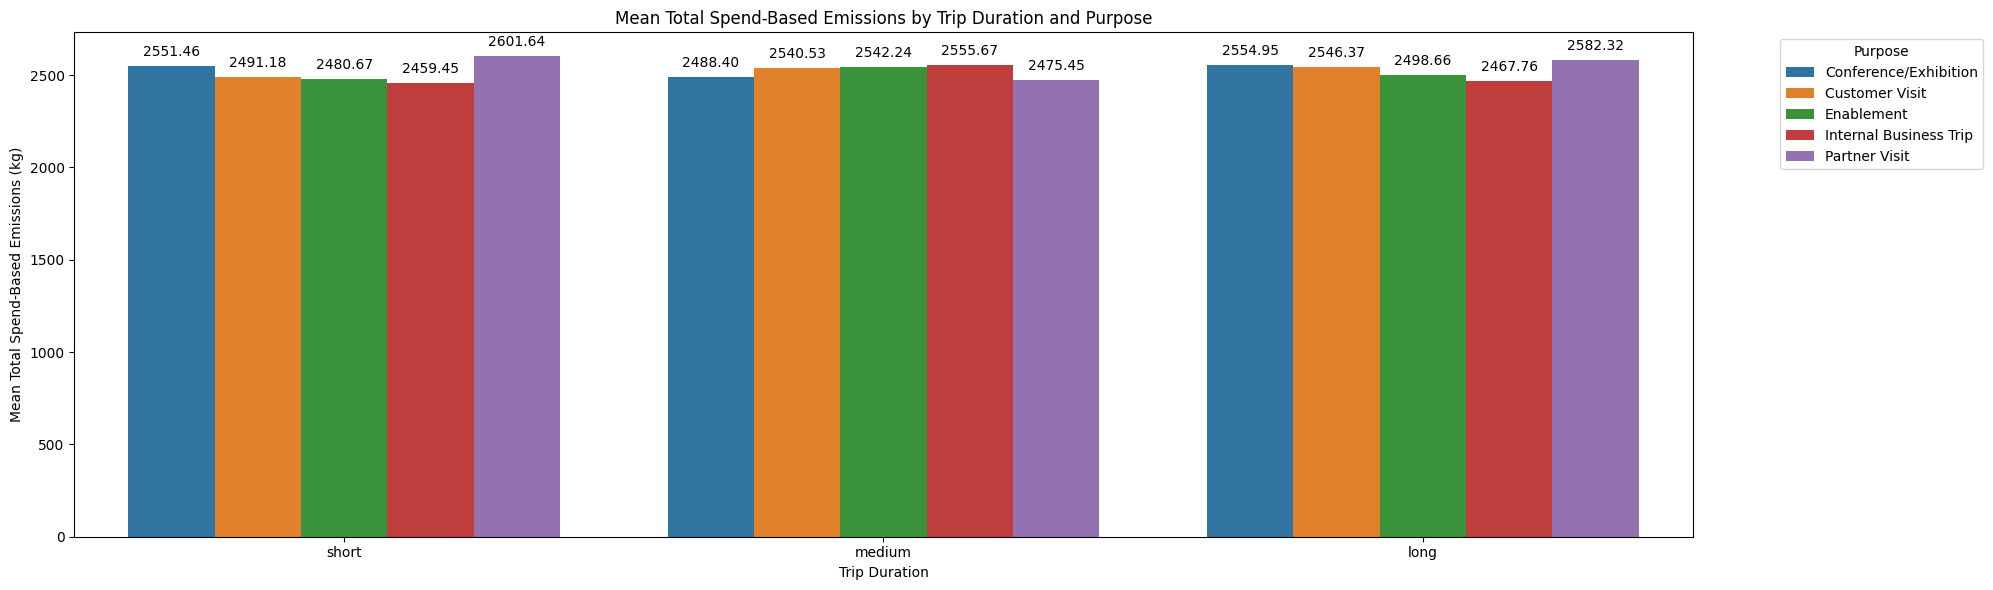

In [96]:
mean_stats = df_all.groupby(['TripDuration', 'Purpose']).agg(
    Count=('TripDuration', 'count'),
    TotalSpendEmissions=('TotalSpendBasedEmissions_in_kg', 'mean'),
).reset_index()

mean_stats

plt.figure(figsize=(20, 6))
correct_order = ['short', 'medium', 'long']

ax = sns.barplot(data=mean_stats, x='TripDuration', y='TotalSpendEmissions', hue='Purpose', order=correct_order)
plt.title("Mean Total Spend-Based Emissions by Trip Duration and Purpose")
plt.xlabel("Trip Duration")
plt.ylabel("Mean Total Spend-Based Emissions (kg)")
plt.legend(title="Purpose", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Add height labels to each bar
for patch in ax.patches:
    height = patch.get_height()
    # Only annotate if the bar has a non-zero height
    if height != 0:
        ax.annotate(f'{height:.2f}',
                    xy=(patch.get_x() + patch.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords='offset points',
                    ha='center', va='bottom')

plt.show()

As we can see above spend based emissions are pretty uniform across purpose in regards to trip duration, maybe the results will differ when adding the 'BusinessUnit' column dimension.

In [26]:
total_spend_by_business = df_all.groupby('BusinessUnit').agg(
    TotalSpendEmissions_in_kg=('TotalSpendBasedEmissions_in_kg', 'sum'),
    Count=('BusinessUnit', 'count')
).reset_index()

total_spend_by_business['SpendEmissionsPerPerson_in_kg'] = total_spend_by_business['TotalSpendEmissions_in_kg'] / total_spend_by_business['Count']

# Sort by total_spend in ascending order
total_spend_by_business_sorted = total_spend_by_business.sort_values(by='TotalSpendEmissions_in_kg', ascending=False)
total_spend_by_business_sorted

,BusinessUnit,TotalSpendEmissions_in_kg,Count,SpendEmissionsPerPerson_in_kg
10,Sales,"52,162,876.72",29105,"1,792.23"
6,Marketing,"29,440,338.46",16311,"1,804.94"
13,Value Engineering,"15,219,236.22",8587,"1,772.36"
0,Customer Support,"13,127,874.71",7122,"1,843.28"
3,Executive Management,"11,303,148.68",6270,"1,802.74"
1,Ecosystem,"8,257,857.41",4665,"1,770.17"
11,Services,"7,854,868.49",4438,"1,769.91"
8,Operations,"6,348,227.96",3623,"1,752.20"
5,Legal,"3,879,536.80",2125,"1,825.66"
7,Office Management,"3,336,304.30",1878,"1,776.52"


This table shows there are **5 departments that contribute massively to the total spend-based emissions** namely:  
 Sales, Marketing, Value Engineering, Customer Support and Executive Management.<br>Let's visualize it below.

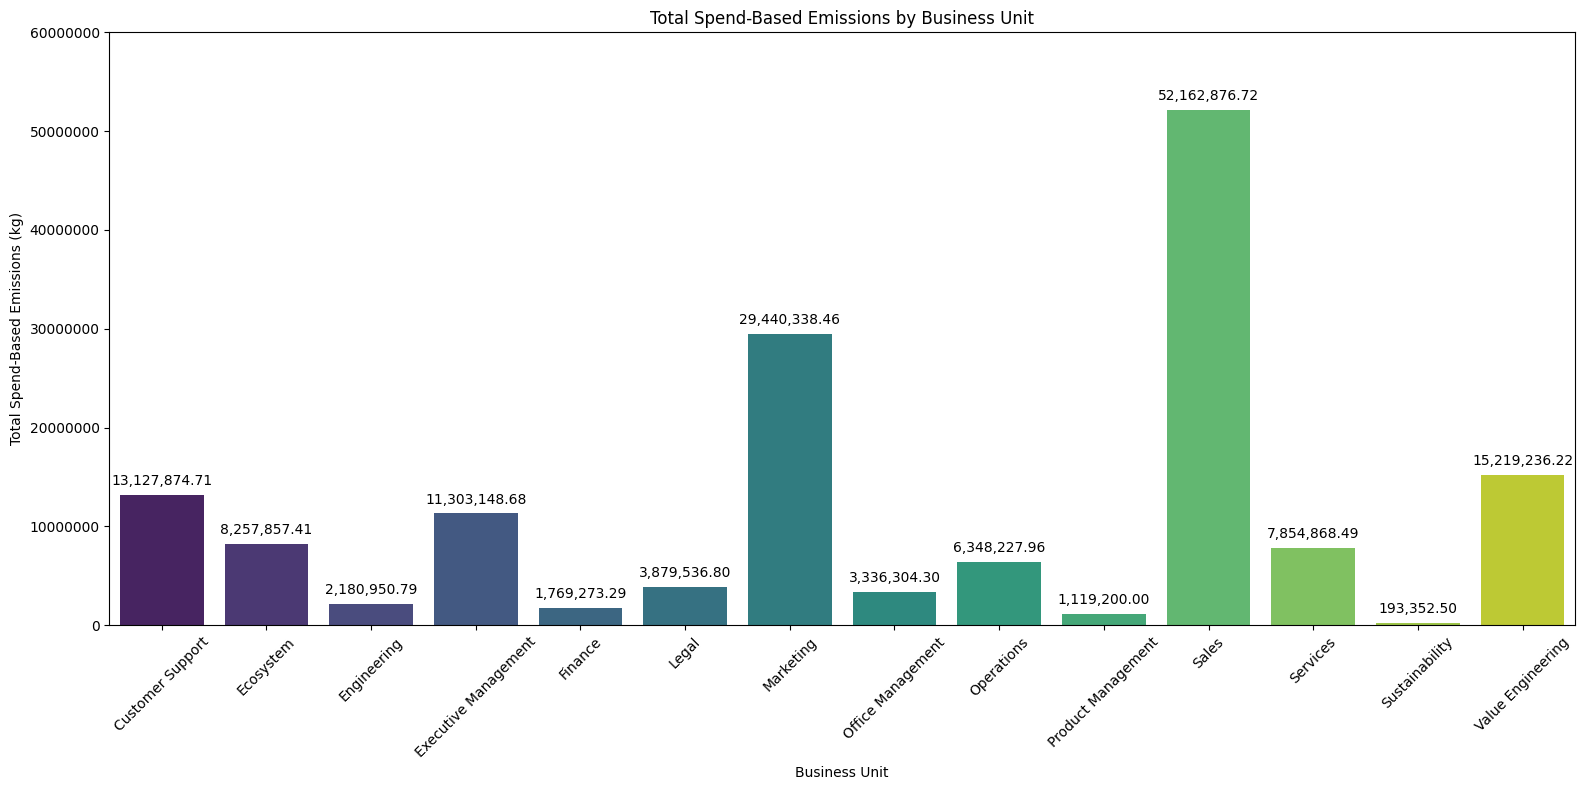

In [27]:
plt.figure(figsize=(16, 8))
ax = sns.barplot(
    data=total_spend_by_business,
    x='BusinessUnit',
    y='TotalSpendEmissions_in_kg',
    hue='BusinessUnit',      
    palette='viridis',
    dodge=False,             
    legend=False             
)

# Disable scientific notation
ax.ticklabel_format(style='plain', axis='y')

plt.title("Total Spend-Based Emissions by Business Unit")
plt.xlabel("Business Unit")
plt.ylabel("Total Spend-Based Emissions (kg)")
plt.xticks(rotation=45)
plt.ylim(0, 60000000)
plt.tight_layout()

# Add value labels
for patch in ax.patches:
    height = patch.get_height()
    ax.annotate(f'{height:,.2f}',
                xy=(patch.get_x() + patch.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()


We know these 5 departments constitute most of the spend-based emissions. Let's see if they also contribute to the most flights taken.   
Should this be the case, this group of business units would be the biggest contributor to distance-based and spend-based emissions.  
For further analysis, it would be more interesting to focus on these groups as the potential reduction in green house gas emissions will be significantly more important.

In [29]:
df.head()

,Id,DepartureLocationCountry,DepartureLocationCity,ArrivalLocationCountry,ArrivalLocationCity,ShippingType,ShippingTypeDescription,Purpose,OutOfPolicy,EntitiyCode,...,distance_km,origin.name,origin.confidence_score,destination.name,destination.confidence_score,direct_emissions.co2e,indirect_emissions.co2e,totalDistanceBasedEmissions_in_kg,TotalSpendBasedEmissions_in_kg,TripDuration
0,1,CN,Beijing,IN,New Delhi,12,Business Class Flight,Customer Visit,No,9000,...,"3,810.00","Beijing, China",1.00,"New Delhi, Delhi, India",1.00,995.50,122.40,"1,117.90","2,401.00",short
1,2,BR,São Paulo,ZA,Johannesburg,12,Business Class Flight,Customer Visit,Yes,8000,...,"7,439.00","Sao Paulo, SP, Brazil",1.00,"Johannesburg, Gauteng, South Africa",1.00,"1,944.00",239.00,"2,183.00","4,903.00",short
2,3,US,New York,MX,Mexico City,11,First Class Flight,Customer Visit,Yes,6000,...,"3,343.00","New York, NY, United States",1.00,"Mexico City, CDMX, Mexico",1.00,621.50,76.41,697.91,451.40,short
3,4,CN,Beijing,GB,London,10,Economy Flight,Internal Business Trip,No,8000,...,"8,153.00","Beijing, China",1.00,"London, England, United Kingdom",1.00,"2,130.00",262.00,"2,392.00",472.10,short
4,5,AU,Sydney,US,Los Angeles,10,Economy Flight,Conference/Exhibition,No,8000,...,"12,061.00","Sydney, NSW 2000, Australia",1.00,"Los Angeles, CA, United States",1.00,"3,151.00",387.50,"3,538.50","3,261.00",medium


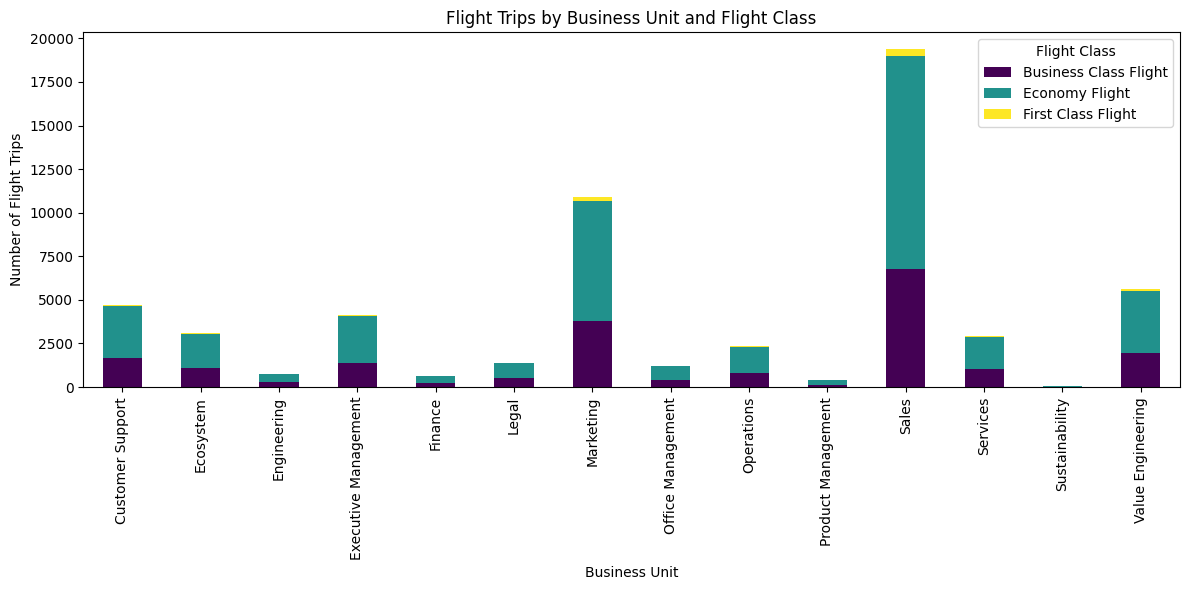

In [36]:
# Mapping ShippingType to FlightClass
df_flights = df[df['ShippingTypeDescription'].str.contains("Flight", case=False, na=False)].copy()
df_flights['FlightClass'] = df_flights['ShippingType'].map(get_shipping_type)

# Group by BusinessUnit and FlightClass to count flight trips
flight_class_stats = df_flights.groupby(['BusinessUnit', 'FlightClass']).size().reset_index(name='count')

# Pivot to create a stacked bar chart
pivot_flight_class = flight_class_stats.pivot(index='BusinessUnit', columns='FlightClass', values='count').fillna(0)

pivot_flight_class.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title("Flight Trips by Business Unit and Flight Class")
plt.xlabel("Business Unit")
plt.ylabel("Number of Flight Trips")
plt.legend(title='Flight Class')
plt.tight_layout()
plt.show()

We can see there appears to be the same 5 departments who also account for most flight travels. Let's dive deeper into them.

In [93]:
def flight_percentage_by_units(business_units, df):
    """
    Calculate the percentage of flight trips accounted for a list of business units.
    """
    df_flights = df[df['ShippingTypeDescription'].str.contains("Flight", case=False, na=False)].copy()
    total_flights_count = df_flights.shape[0]
    
    percentages = {}
    for unit in business_units:
        unit_flights_count = df_flights[df_flights['BusinessUnit'] == unit].shape[0]
        percentage = (unit_flights_count / total_flights_count * 100) if total_flights_count else 0
        percentages[unit] = percentage
        print(f"{unit} department accounts for {percentage:.2f}% of flight trips.")
    
    return percentages

business_units = ['Sales', 'Marketing', 'Value Engineering', 'Customer Support', 'Executive Management']
total_flights_percentage = flight_percentage_by_units(business_units, df)

# Calculate the sum of percentages of the provided business units
sum_percentages = sum(total_flights_percentage.values())
print(f"\nTotal amount of flights for provided business units in regards to total flights: {sum_percentages:.2f}%")

Sales department accounts for 33.57% of flight trips.
Marketing department accounts for 18.92% of flight trips.
Value Engineering department accounts for 9.71% of flight trips.
Customer Support department accounts for 8.20% of flight trips.
Executive Management department accounts for 7.19% of flight trips.

Total amount of flights for provided business units in regards to total flights: 77.59%


In [43]:
def flight_percentage_by_flight_class_by_business_unit(business_units, df):
    """
    Calculate the percentage of flight trips by flight class for each specified business unit,
    with the percentage calculated relative to the total count of that flight class.
    """
    df_flights = df[df['ShippingTypeDescription'].str.contains("Flight", case=False, na=False)].copy()
    if business_units:
        df_flights = df_flights[df_flights['BusinessUnit'].isin(business_units)]
    df_flights['FlightClass'] = df_flights['ShippingType'].map(get_shipping_type)
    grouped = df_flights.groupby(['BusinessUnit', 'FlightClass']).size().reset_index(name='count')
    total_by_class = df_flights.groupby('FlightClass').size().reset_index(name='class_total')
    merged = grouped.merge(total_by_class, on='FlightClass')
    merged['percentage'] = merged['count'] / merged['class_total'] * 100
    return merged


result = flight_percentage_by_flight_class_by_business_unit(business_units, df)
result


,BusinessUnit,FlightClass,count,class_total,percentage
0,Customer Support,Business Class Flight,1672,15533,10.76
1,Customer Support,Economy Flight,2951,28258,10.44
2,Customer Support,First Class Flight,110,988,11.13
3,Executive Management,Business Class Flight,1383,15533,8.90
4,Executive Management,Economy Flight,2668,28258,9.44
5,Executive Management,First Class Flight,101,988,10.22
6,Marketing,Business Class Flight,3762,15533,24.22
7,Marketing,Economy Flight,6898,28258,24.41
8,Marketing,First Class Flight,259,988,26.21
9,Sales,Business Class Flight,6777,15533,43.63


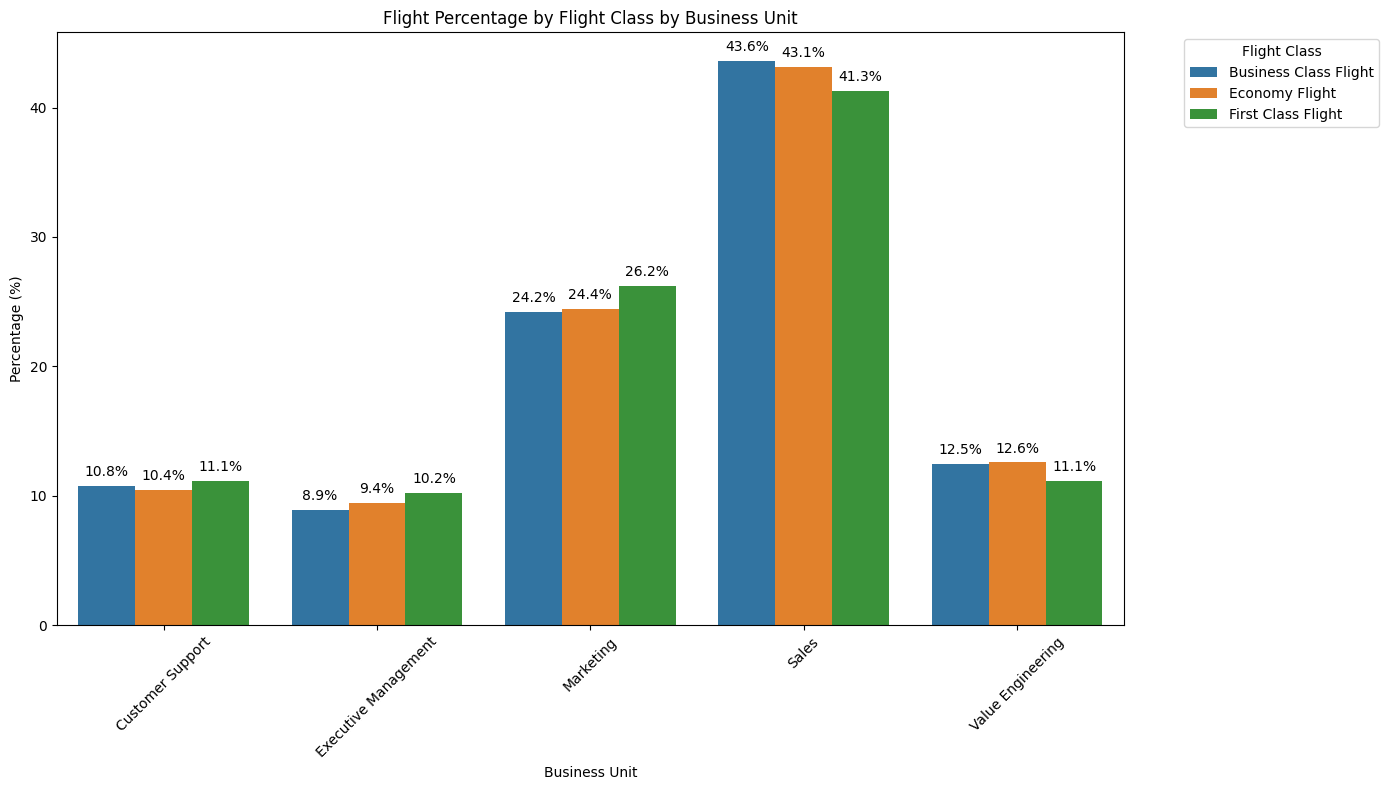

In [44]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=result, x='BusinessUnit', y='percentage', hue='FlightClass')

plt.title("Flight Percentage by Flight Class by Business Unit")
plt.xlabel("Business Unit")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)
plt.legend(title='Flight Class', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add value labels on top of each bar, skipping zero heights
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%',
                    xy=(patch.get_x() + patch.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords='offset points',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


We can see the Sales and Marketing team are both responsible for more than 50% of all flights in our dataset. Should the business want to reduce their green house gas emissions, directing their efforts to these two departments would result in the best efforts.

## 4.2 Examining Distance-Based Emissions

I want to segment the distance-based emissions per ShippingTypeDescription(car, train, flight), I created a 'TransportCategory' column for easier access.

In [49]:
# Creating a Transport Category
conditions = [
    df['ShippingType'].isin([10, 11, 12]),  # Flight: Economy, First, Business Flight
    df['ShippingType'] == 4                 # Train
]

choices = ['Flight', 'Train']

# For all other cases, default to 'Car'
df['TransportCategory'] = np.select(conditions, choices, default='Car')

Then, I calculated the amount of trips per Transport Category as well as the average distance and its standard deviation.<br>I then calculated the average emissions in kg per Transport Category with its standard deviation.

In [76]:
# Segment dataFrame per Transport Category
df_trains = df[df['TransportCategory'] == 'Train']
df_cars = df[df['TransportCategory'] == 'Car']
df_flights = df[df['TransportCategory'] == 'Flight']

# Concatenate the DataFrames into one
df_all = pd.concat([df_trains, df_cars, df_flights], ignore_index=True)

# Compute the count, median distance, and median emissions per transport category
mean_stats = df_all.groupby('TransportCategory').agg(
    count=('TransportCategory', 'count'),
    mean_distance=('distance_km', 'mean'),
    std_distance=('distance_km', 'std'),
    mean_emissions_in_kg=('totalDistanceBasedEmissions_in_kg', 'mean'),
    std_emissions_in_kg=('totalDistanceBasedEmissions_in_kg', 'std')
).reset_index()

# Calculate the total distance and total emissions using the count and means
mean_stats['total_distance_mean'] = mean_stats['count'] * mean_stats['mean_distance']
mean_stats['total_emissions_mean_in_kg'] = mean_stats['count'] * mean_stats['mean_emissions_in_kg']
mean_stats['mean_emission_per_1000km_in_kg'] = (mean_stats['mean_emissions_in_kg'] / mean_stats['mean_distance']) * 1000

mean_stats


,TransportCategory,count,mean_distance,std_distance,mean_emissions_in_kg,std_emissions_in_kg,total_distance_mean,total_emissions_mean_in_kg,mean_emission_per_1000km_in_kg
0,Car,25079,"2,835.95","2,564.00",608.53,545.00,"71,122,867.79","15,261,291.62",214.58
1,Flight,57712,"7,770.21","4,767.08","2,251.83","1,432.58","448,434,407.70","129,957,583.13",289.80
2,Train,4262,"4,270.73","3,503.57",235.16,234.66,"18,201,871.81","1,002,234.24",55.06


From this table, we can observe that although the average distance by train is almost double that of car travels, train average emissions are almost 3 times lower than those of cars.<br>To exemplify this difference, I created a scaled measure of average emissions per 1000km travels and found train emissions are almost 1/4 of those by cars.<br>Having said this, let's explore emissions by Business Unit and Car class, maybe the same pattern of flights repeats itself with cars.

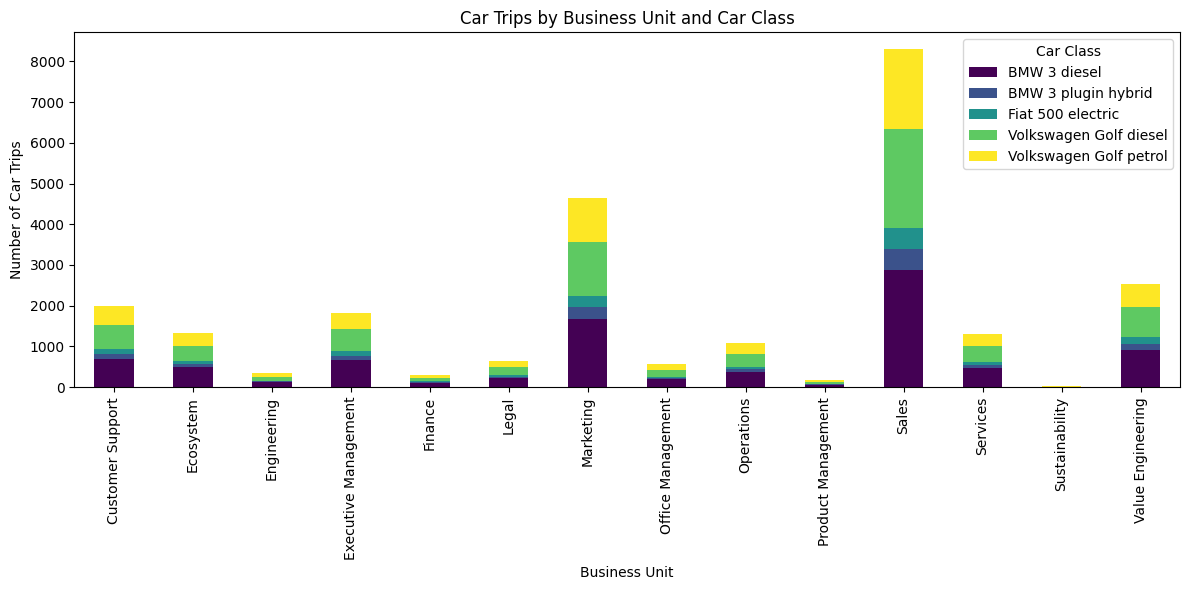

In [53]:
# Mapping ShippingType to CarClass
df_cars = df[df['TransportCategory'] == 'Car'].copy()
df_cars['CarType'] = df_cars['ShippingType'].map(get_shipping_type)

# Group by BusinessUnit and CarClass to count Car trips
Car_class_stats = df_cars.groupby(['BusinessUnit', 'CarType']).size().reset_index(name='count')

# Pivot to create a stacked bar chart
pivot_Car_class = Car_class_stats.pivot(index='BusinessUnit', columns='CarType', values='count').fillna(0)

pivot_Car_class.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title("Car Trips by Business Unit and Car Class")
plt.xlabel("Business Unit")
plt.ylabel("Number of Car Trips")
plt.legend(title='Car Class')
plt.tight_layout()
plt.show()

The Sales business unit, again are the ones that use the most cars, followed by marketing.

Let's examine car travels by CarType, I hypothesize the electric type will have the least emissions in kg compared to other car types.

In [61]:
df_cars = df[df['TransportCategory'] == 'Car'].copy()

car_stats = df_cars.groupby(['TransportCategory', 'ShippingTypeDescription']).agg(
    count=('TransportCategory', 'count'),
    mean_distance=('distance_km', 'mean'),
    std_distance=('distance_km', 'std'),
    mean_emissions_in_kg=('totalDistanceBasedEmissions_in_kg', 'mean'),
    std_emissions_in_kg=('totalDistanceBasedEmissions_in_kg', 'std')
).reset_index()

car_stats

,TransportCategory,ShippingTypeDescription,count,mean_distance,std_distance,mean_emissions_in_kg,std_emissions_in_kg
0,Car,BMW 3 diesel,8872,"2,807.39","2,541.20",602.55,540.42
1,Car,BMW 3 plugin hybrid,1511,"2,834.92","2,539.63",608.67,540.23
2,Car,Fiat 500 electric,1501,"2,758.48","2,555.61",591.83,543.23
3,Car,Volkswagen Golf diesel,7289,"2,831.09","2,572.37",607.44,546.65
4,Car,Volkswagen Golf petrol,5906,"2,904.71","2,595.24",623.04,551.31


I was wrong to think this, actually the diesel and plugin hybrid type of cars have the lowest emissions however the different is negligible.<br>In conclusion, the different car types do not really matters, should the business want to lower their emissions.<br>The most significant measure to be taken would be to reduce the amount of car trips in favor of rail travels. 

Here, I constructed an example measure the business could take, should it want to lower their brand's Green House Gas emissions.<br>I chose to take half the amount of car trips from the Sales Department and convert them to train travels.<br>The reasons behind this example are:
- Sales Unit has the biggest impact on car travels in the dataset
- Train emissions are on average almost a 1/4 of car emissions for the same distance.  

In [95]:
half_carTrips_Sales_Unit = car_stats['count'].sum() / 2

cars_mean = mean_stats[mean_stats['TransportCategory'] == 'Car']['mean_emission_per_1000km_in_kg'].iloc[0]
trains_mean = mean_stats[mean_stats['TransportCategory'] == 'Train']['mean_emission_per_1000km_in_kg'].iloc[0]

ratio = cars_mean / trains_mean
half_carEmissions_Sales_Unit = half_carTrips_Sales_Unit * cars_mean
print(f"The current car distance-based emissions in kg for half of the Sales Unit are: {half_carEmissions_Sales_Unit:,.2f}")

decrease_distance_emissions = half_carEmissions_Sales_Unit / ratio
print(f"If half the Sales team traveled via trains, they would save: {(half_carEmissions_Sales_Unit - decrease_distance_emissions):,.2f}kg")

percentage_decrease_in_emissions = decrease_distance_emissions * 100 / df['totalDistanceBasedEmissions_in_kg'].sum() 
print(f"This acounts for {percentage_decrease_in_emissions:.2f}% of total company emissions, meaning about {decrease_distance_emissions:,.2f}kg of reduction in co2e emissions")


The current car distance-based emissions in kg for half of the Sales Unit are: 2,690,681.24
If half the Sales team traveled via trains, they would save: 2,000,229.39kg
This acounts for 0.47% of total company emissions, meaning about 690,451.86kg of reduction in co2e emissions
